In [ ]:
import numpy as np
from scipy import integrate, interpolate
from scipy.signal import gaussian, convolve
from scipy.special import erf
import matplotlib.pyplot as plt

## Q2: Interpolation error

There are a large number of different interpolation schemes available through scipy.  Let's test them out.

Create a python function, $f(x)$, that is your true function (make it complicated!).  Now create $N$ samples of it (either regularly spaced or irregularly spaced).

Try some of the different interolation routines.  `interpolate.interp1d` takes a `kind` argument that let's you choose the order of the interpolation.  Measure the error in the method, by comparing the interpolated result with the actual function value.  

Then do the same cubic splines (look at `CubicSpline`)

Plot the resulting interpolant.

In [108]:
def ferrsq(x, x0, y0, h, a, b, c):
    return y0 + h / 2 * erf((x - x0) * a) + b * x + c * x**2

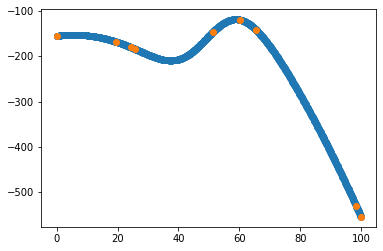

In [180]:
x = np.linspace(0, 100, 1000)
pars = (50, 0, 310, 0.08, 0.9, -0.08)
y = ferrsq(x, *pars)
plt.scatter(x, y)
samples_x = np.random.choice(x[1:-1], 7)
samples_x = np.append(samples_x, [0, 100])
samples_x.sort()
samples_y = ferrsq(samples_x, *pars)
plt.scatter(samples_x, samples_y)

In [96]:
 p = interpolate.interp1d(samples_x, samples_y, kind='cubic')	

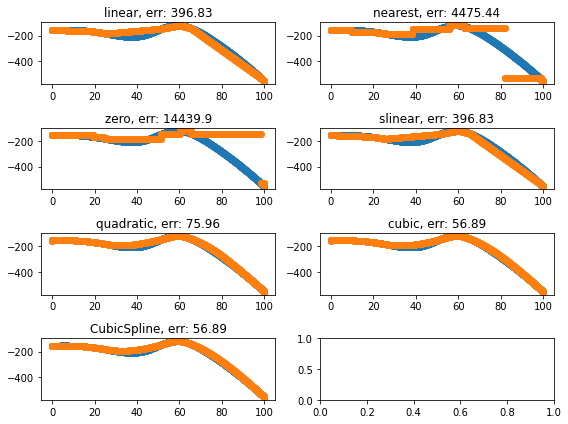

In [183]:
kinds = ["linear", "nearest", "zero", "slinear", "quadratic", "cubic"]

fig, axs = plt.subplots((len(kinds) + 2) // 2, 2, figsize=(8, 6))
axs = axs.flatten()

for i, kind in enumerate(kinds):
    if i < len(axs):
        p = interpolate.interp1d(samples_x, samples_y, kind=kind)
        axs[i].scatter(x, ferrsq(x, *pars), label=kind)
        axs[i].scatter(x, p(x))

        err = np.sum((p(x) - ferrsq(x, *pars)) ** 2) / len(x)
        err = round(err, 2)
        axs[i].set_title(f"{kind}, err: {err}")

p = interpolate.CubicSpline(samples_x, samples_y)
axs[i + 1].scatter(x, ferrsq(x, *pars))
axs[i + 1].scatter(x, p(x))
err = np.sum((p(x) - ferrsq(x, *pars)) ** 2) / len(x)
err = round(err, 2)
axs[i + 1].set_title(f"CubicSpline, err: {err}")

plt.tight_layout()

## Q3: Basins of attraction

Consider the function

$$q(x) = x^3 - 2x^2 - 11x + 12$$

This has 3 roots has you should find them all. This equation is known to cause problems for some root-finding methods  becauses it exhibits [basis of attraction](https://en.wikipedia.org/wiki/Newton%27s_method#Basins_of_attraction) -- very closely spaced initial guesses leave to very different roots.

Use the scipy `optimize.brentq` method to find the roots.  You might need to play around with the intervals to find all 3 roots (try plotting the function to help)

-3.0 1.0 4.0


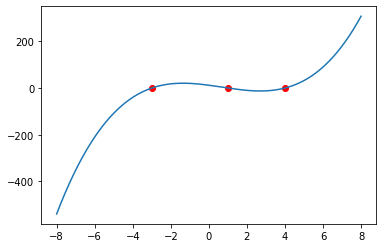

In [26]:
from scipy import optimize


def q(x):
    return x**3 - 2 * x**2 - 11 * x + 12


fig, ax = plt.subplots()
x = np.linspace(-8, 8, 1000)
ax.plot(x, q(x))

root1 = optimize.brentq(q, -5, -0.8)
root2 = optimize.brentq(q, 0, 3)
root3 = optimize.brentq(q, 3, 5)
ax.scatter([root1, root2, root3], [q(root1), q(root2), q(root3)], c="red")
print(root1, root2, root3)

## Q5: Planetary orbits

We want to consider planetary orbits.  To do this, we need to solve Newton's second law together with Newton's law of gravity.  If we restrict ourselves to the x-y plane, then there are 4 quantities we need to solve for: $x$, $y$, $v_x$, and $v_y$.  These evolve according to:

\begin{align*}
\frac{dx}{dt} &= v_x \\
\frac{dy}{dt} &= v_y \\
\frac{dv_x}{dt} &= a_x = -\frac{GM_\star x}{r^3} \\
\frac{dv_y}{dt} &= a_y = -\frac{GM_\star y}{r^3}
\end{align*}

To integrate these forward in time, we need an initial condition for each quantity.  We'll setup our system such that the Sun is at the origin (that will be one focus), and the planet begins at perihelion and orbits counterclockwise. 

![orbit_setup.png](attachment:orbit_setup.png)

The distance of perihelion from the focus is:

$$r_p = a (1 - e)$$

where $a$ is the semi-major axis and $e$ is the eccentricity.  The perihelion velocity is all in the $y$ direction and is:

$$v_y = v_p = \sqrt{\frac{GM_\star}{a} \frac{1+e}{1-e}}$$

We'll work in units of AU, years, and solar masses, in which case, $GM_\star = 4\pi^2$ (for the Sun).  

Your initial conditions should be:

  * $x(t=0) = r_p$
  * $y(t=0) = 0$
  * $v_x(t=0) = 0$
  * $v_y(t=0) = v_p$

Use the scipy ODE integration methods to integrate an orbit and plot it

In [303]:
a = 1
e = 0.5
###

GM_sun = 4 * np.pi**2
r_p = a * (1 - e)
vy = vp = np.sqrt(GM_sun * (1 + e) / (a * (1 - e)))

# initial conditions
x0 = r_p
y0 = 0
vx0 = 0
vy0 = vp

arr0 = [x0, y0, vx0, vy0]


def orbit(d, t):
    x, y, vx, vy = d
    r = np.sqrt(x**2 + y**2)
    ax = -GM_sun * x / r**3
    ay = -GM_sun * y / r**3
    return [vx, vy, ax, ay]

In [304]:
result = integrate.odeint(orbit, arr0, np.linspace(0, 2, 1000)).T
x, y, vx, vy = result

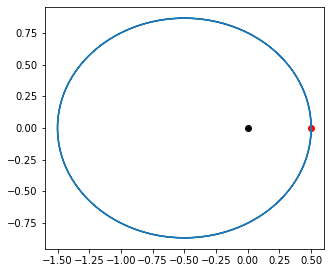

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_aspect("equal")
ax.plot(x, y)
ax.scatter(x[0], y[0], c="r")
ax.scatter(0, 0, c="black")

## Q7: Noisy signal

A convolution is defined as:  

  \begin{equation}                                                                           
    (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau                   
  \end{equation}                                                                             

  It is easy to compute this with FFTs, via the _convolution theorem_,                                                                        
  \begin{equation}                                         
    \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\}                                          
  \end{equation}                                         
  That is: the Fourier transform of the convolution of $f$ and $g$ is simply
  the product of the individual transforms of $f$ and $g$.  This allows us
  to compute the convolution via multiplication in Fourier space and then take
  the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution in real space:
  
  \begin{equation}
  f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\}
  \end{equation}
  
A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian.  We'll do that here.

Here's some noisy data we'll work with

In [185]:
def fdata(x, L):
    A = L / 10.0
    return (
        2 * np.sin(2 * np.pi * x / L)
        + x * (L - x) ** 2 / L**3 * np.cos(x)
        + 5 * x * (L - x) / L**2
        + A / 2
        + 0.1 * A * np.sin(13 * np.pi * x / L)
    )


N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5 * np.random.randn(N)

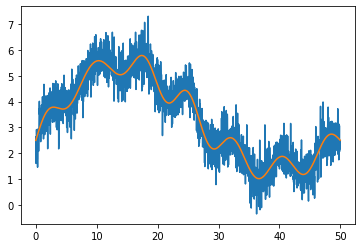

In [186]:
plt.plot(x, noisy)
plt.plot(x, orig)

SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

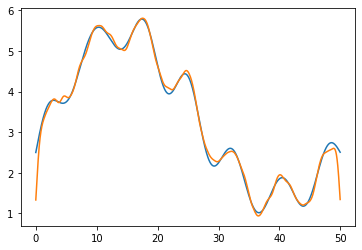

In [225]:
gsn = gaussian(100, std=18)
gsn /= np.sum(gsn)


# Convolve the noisy data with the Gaussian kernel
convolved = convolve(noisy, gsn, mode="same")

# Plot the convolved data
plt.plot(x, orig)
plt.plot(x, convolved)